<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/representaciones_latentes/introducci%C3%B3n_a_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción

Un autocodificador o *autoencoder* es un tipo específico de red neuronal que está diseñado principalmente para codificar la entrada en una representación comprimida y significativa para luego decodificarla de manera que la entrada reconstruida sea lo más similar posible a la original. Un Autoencoder es una arquitectura de cuello de botella que convierte una entrada de alta dimensión en un vector latente de baja dimensión (codificador) y luego realiza una reconstrucción de la entrada con este mismo vector latente (el decodificador).

En este *notebook* se comparten un par de ejemplos con Autoencoders. El primero es un ejemplo con datos estructurados y el segundo con imágenes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

#### Ejemplo #1

Primero se crea un conjunto de datos sintéticos para que actúe como entrada para el autocodificador con la siguiente función.

In [2]:
def generate_data(m):
    """Traza m puntos aleatorios en un plano 3D"""
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:,0] = np.cos(angles) + np.sin(angles)/2 + 0.1 * np.random.rand(m)/2
    data[:,1] = np.sin(angles) * 0.7 + 0.1 * np.random.rand(m) / 2
    data[:,2] = data[:,0] * 0.1 + data[:,1] * 0.3 + 0.1 * np.random.rand(m)

    return data

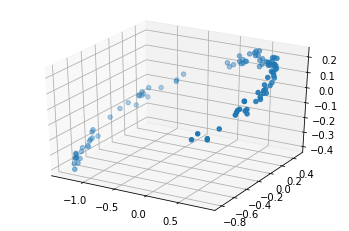

In [3]:
X_train = generate_data(100)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

# Vista previa de los datos
ax = plt.axes(projection="3d")
ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2], cmap="Blues");

### Construcción del modelo

In [4]:
from tensorflow.keras.models import Sequential

In [5]:
encoder = Sequential([tf.keras.layers.Dense(2, input_shape=[3])])
decoder = Sequential([tf.keras.layers.Dense(3, input_shape=[2])])

autoencoder = Sequential([encoder, decoder])

In [6]:
autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.1))

In [7]:
%%time
history = autoencoder.fit(X_train, X_train, epochs=200)

Epoch 1/200
4/4 [==============================] - 7s 36ms/step - loss: 0.2836
Epoch 2/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1315
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0858
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0614
Epoch 5/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 6/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0458
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0442
Epoch 8/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 9/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0414
Epoch 10/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0406
Epoch 11/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0399
Epoch 12/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0392
Epoch 13/200
4/4 [==============================] - 0s 

### Codificador (Encoder)

Como se mencionó, se puede usar el codificador para comprimir la entrada a dos dimensiones.

In [8]:
# Codificar los datos
codings = encoder.predict(X_train)

# Muestra los vectores de entrada-salida del codificador
print(f'[INFO] Vector de entrada: {X_train[0]}')
print(f'[INFO] Vector codificado: {codings[0]}')

4/4 [==============================] - 0s 2ms/step
[INFO] Vector de entrada: [-1.12772203 -0.09256656 -0.11441478]
[INFO] Vector codificado: [-0.98750675 -0.03874668]


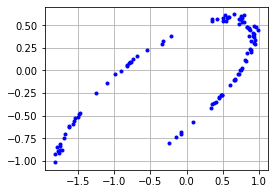

In [9]:
# Trazar todas las salidas del codificador
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Decodificador (Decoder)

El decodificador intenta reconstruir la entrada original. Vea las salidas a continuación. Aunque no es perfecto, sigue la forma general de la entrada original.

In [10]:
# Decodificar la salida del codificador
decodings = decoder.predict(codings)

# Muestra la entrada y salida del codificador y decodificador
print(f'[INFO] Observación de entrada: {X_train[0]}')
print(f'[INFO] Vector codificado: {codings[0]}')
print(f'[INFO] Vector decodificado: {decodings[0]}')

4/4 [==============================] - 0s 4ms/step
[INFO] Observación de entrada: [-1.12772203 -0.09256656 -0.11441478]
[INFO] Vector codificado: [-0.98750675 -0.03874668]
[INFO] Vector decodificado: [-1.120008   -0.08184484 -0.13495016]


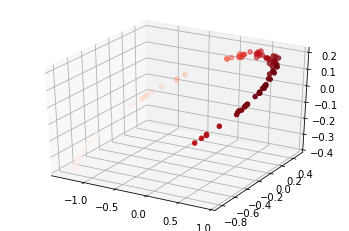

In [11]:
# Trazar la salida del decodificador

ax = plt.axes(projection='3d')
ax.scatter3D(decodings[:, 0], decodings[:, 1], decodings[:, 2], c=decodings[:, 0], cmap="Reds");

#### Ejemplo #2

Se carga el conjunto de datos MNIST de TFDS particionado en conjuntos de entrenamiento y prueba. Primero se define una función de preprocesamiento para normalizar y aplanar las imágenes. Dado que se entrena un auto-codificador, devolverá dos veces la misma imagen porque los datos de entrada también serán la viariable objetivo o la etiqueta durante el entrenamiento.

In [12]:
def map_image(image, label):
    # Normaliza y aplana las imágenes. Devuelve la misma imagen tanto como entrada como salida (etiqueta)
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0
    image = tf.reshape(image, shape=(784,))
    return image, image

In [13]:
batch_size = 128
buffer_size = 1024

In [14]:
train_dataset = tfds.load("mnist", as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [15]:
test_dataset = tfds.load("mnist", as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(batch_size).repeat()

In [16]:
def simple_autoencoder(inputs):
    """Construye el codificador y decodificador usando capas densas"""
    encoder = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
    decoder = tf.keras.layers.Dense(units=784, activation="sigmoid")(encoder)
    return encoder, decoder

In [17]:
inputs = tf.keras.layers.Input(shape=(784,))
encoder_output, decoder_output = simple_autoencoder(inputs)
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

In [18]:
train_steps = 60000 // batch_size
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")

In [19]:
%%time
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 10s 17ms/step - loss: 0.2276
Epoch 2/50
468/468 [==============================] - 4s 8ms/step - loss: 0.1424
Epoch 3/50
468/468 [==============================] - 5s 11ms/step - loss: 0.1193
Epoch 4/50
468/468 [==============================] - 5s 10ms/step - loss: 0.1077
Epoch 5/50
468/468 [==============================] - 4s 8ms/step - loss: 0.1013
Epoch 6/50
468/468 [==============================] - 5s 11ms/step - loss: 0.0977
Epoch 7/50
468/468 [==============================] - 4s 9ms/step - loss: 0.0959
Epoch 8/50
468/468 [==============================] - 5s 11ms/step - loss: 0.0950
Epoch 9/50
468/468 [==============================] - 5s 11ms/step - loss: 0.0945
Epoch 10/50
468/468 [==============================] - 4s 8ms/step - loss: 0.0942
Epoch 11/50
468/468 [==============================] - 4s 8ms/step - loss: 0.0940
Epoch 12/50
468/468 [==============================] - 4s 9ms/step - loss: 0.0938
Epoch 13/50
468/46

In [20]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    # Muestra los resultados en una fila
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image, cmap='gray')

In [21]:
def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 4)):
    # Muestra los valores de salida de entrada, codificados y decodificados
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28, 28,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28, 28,))

1/1 [==============================] - 0s 102ms/step


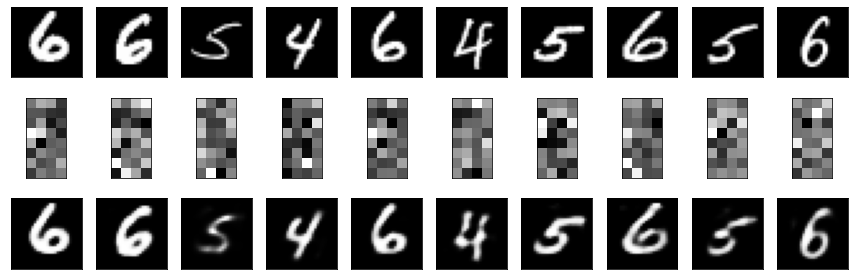

In [22]:
# Toma un batch del conjunto de datos
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(batch_size, size=10)

# Obtiene la salida del codificador
encoded_predicted = encoder_model.predict(test_dataset)

# Obtiene una predicción para el lote de prueba
simple_predicted = autoencoder_model.predict(test_dataset)

# Muestra 10 observaciones, sus codificaciones y los valores decodificados
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])

#### Ejemplo #3

Se busca robustecer el modelo previo añadiendo más capas de profundidad, es decir, se construye una arquitectura de tipo autocodificador profundo.

In [23]:
def deep_autoencoder(inputs):
    # Construye el codificador y decodificador usando capas densas
    encoder = tf.keras.layers.Dense(units=128, activation="relu")(inputs)
    encoder = tf.keras.layers.Dense(units=64,  activation="relu")(encoder)
    encoder = tf.keras.layers.Dense(units=32,  activation="relu")(encoder)

    decoder = tf.keras.layers.Dense(units=64,  activation="relu")(encoder)
    decoder = tf.keras.layers.Dense(units=128, activation="relu")(encoder)
    decoder = tf.keras.layers.Dense(units=784, activation="sigmoid")(encoder)

    return encoder, decoder

In [24]:
inputs = tf.keras.layers.Input(shape=(784,))
deep_encoder_output, deep_autoencoder_output = deep_autoencoder(inputs)
deep_encoder_model = tf.keras.Model(inputs=inputs, outputs=deep_encoder_output)
deep_autoencoder_model = tf.keras.Model(inputs=inputs, outputs=deep_autoencoder_output)

In [27]:
train_steps = 60000 // batch_size
deep_autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")

In [28]:
%%time
deep_auto_history = deep_autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 5s 7ms/step - loss: 0.2169
Epoch 2/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1313
Epoch 3/50
468/468 [==============================] - 6s 13ms/step - loss: 0.1148
Epoch 4/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1075
Epoch 5/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1041
Epoch 6/50
468/468 [==============================] - 4s 9ms/step - loss: 0.1017
Epoch 7/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0995
Epoch 8/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0971
Epoch 9/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0950
Epoch 10/50
468/468 [==============================] - 4s 9ms/step - loss: 0.0935
Epoch 11/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0924
Epoch 12/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0916
Epoch 13/50
468/468 [===

1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 116ms/step


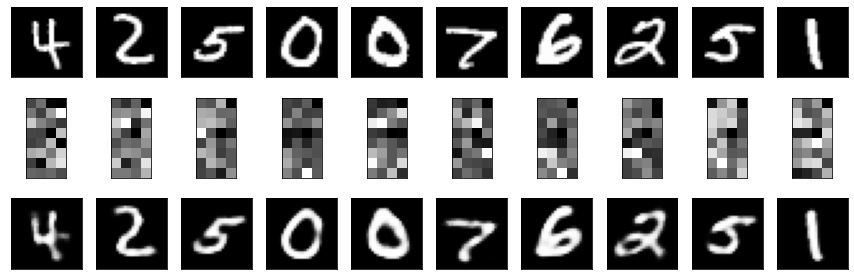

In [29]:
# Toma un batch del conjunto de datos
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(batch_size, size=10)

# Obtiene la salida del codificador
encoded_predicted = deep_encoder_model.predict(test_dataset)

# Obtiene una predicción para el lote de prueba
deep_predicted = deep_autoencoder_model.predict(test_dataset)

# Muestra 10 observaciones, sus codificaciones y los valores decodificados
display_results(output_samples[idxs], encoded_predicted[idxs], deep_predicted[idxs])

#### Ejemplo 4

Se utilizará el conjunto de datos Fashion-MNIST para la construcción de un modelo de autocodificación utilizando redes neuronales convolucionales.

In [40]:
def map_image(image, label):
    # Normaliza y aplana las imágenes. Devuelve la misma imagen tanto como entrada como salida (etiqueta)
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0
    # image = tf.reshape(image, shape=(784,))
    return image, image

In [41]:
train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat()

In [42]:
test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(batch_size).repeat()

Como se mencionó anteriormente, se utilizarán capas convolucionales para construir el modelo. Este se compone de tres partes principales: codificador, cuello de botella y decodificador.

El codificador, al igual que en los ejemplos anteriores, se contraerá con cada capa adicional. Las características se generan con las capas Conv2D, mientras que las capas de agrupación máxima reducen la dimensionalidad.

In [43]:
def encoder(inputs):
    """Defines the encoder with two Conv2D and max pooling layers"""
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

    return max_pool_2

Se utiliza una capa de cuello de botella para obtener más características, pero sin reducir más la dimensión después. Se inserta otra capa para visualizar la salida del codificador.

In [44]:
def bottle_neck(inputs):
    """Defines the bottleneck"""
    bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(bottle_neck)
    return bottle_neck, encoder_visualization

El decodificador volverá a muestrear la salida del cuello de botella al tamaño de imagen original.

In [45]:
def decoder(inputs):
    """Defines the decoder path to upsample back to original image size."""
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up_sample_1)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)
    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up_sample_1)
    return conv_3 

Se puede ahora construir el codificador automático completo usando las funciones anteriores.

In [46]:
def convolutional_auto_encoder():
    """Builds the entire autoencoder model."""
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)

    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

    return model, encoder_model

In [47]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 256)         2951

In [48]:
train_steps = 60000 // batch_size
valid_steps = 60000 // batch_size

In [49]:
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')

In [50]:
%%time
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 20s 26ms/step - loss: 0.2887 - val_loss: 0.2683
Epoch 2/50
468/468 [==============================] - 11s 22ms/step - loss: 0.2615 - val_loss: 0.2602
Epoch 3/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2562 - val_loss: 0.2567
Epoch 4/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2534 - val_loss: 0.2543
Epoch 5/50
468/468 [==============================] - 12s 26ms/step - loss: 0.2518 - val_loss: 0.2529
Epoch 6/50
468/468 [==============================] - 12s 27ms/step - loss: 0.2508 - val_loss: 0.2522
Epoch 7/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2499 - val_loss: 0.2514
Epoch 8/50
468/468 [==============================] - 10s 21ms/step - loss: 0.2492 - val_loss: 0.2508
Epoch 9/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2487 - val_loss: 0.2504
Epoch 10/50
468/468 [==============================] - 10s 22ms/step - loss: 0.248

Se visualiza la salida del modelo.

1/1 [==============================] - 0s 166ms/step


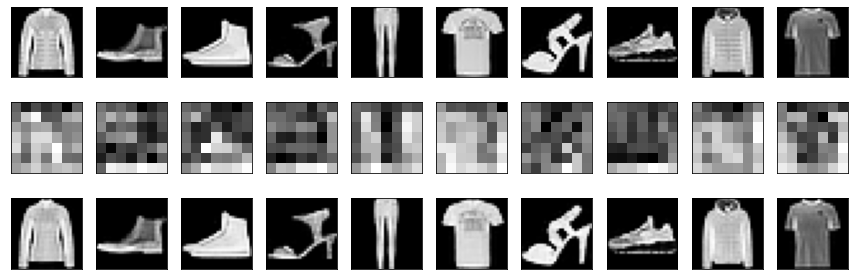

In [51]:
# Toma un batch del conjunto de datos
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# Se toman 10 índices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Prepara muestras para prueba de un lote de 10 imágenes
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# Obtiene la salida del codificador
encoded = convolutional_encoder_model.predict(conv_output_samples)

# Obtiene una predicción para el lote de prueba
predicted = convolutional_model.predict(conv_output_samples)

# Muestra 10 observaciones, sus codificaciones y los valores decodificados
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))